# Sophia Hart
Women in Data Science (WiDS) Datathon Challenge #2, 2024

Kaggle Competition

Healthcare Inequality

Leveraged real-world data containing patient demographics, diagnoses, insurance, and climate patterns and predicted days to diagnose metastatic TNBC breast cancer using a neural network with TensorFlow. Cleaned data using multivariate imputation and transformed data using one hot encoder.

In [1]:
from google.colab import files
import io

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf

In [ ]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [ ]:
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
display(train_df.head(5))


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.5,74.8,80.0,81.7,78.3,74.6,60.0,43.0,41.2,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.4,...,49.3,72.9,77.4,77.4,75.8,72.6,58.4,39.7,39.7,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.5,70.3,78.6,87.2,85.5,80.8,70.8,62.7,55.6,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.3,63.1,67.5,75.9,75.2,71.1,69.0,65.5,59.5,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.5,60.2,64.8,69.8,70.1,68.1,65.4,60.7,54.1,286


In [ ]:
test_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [ ]:
train_df.shape

(13173, 152)

In [ ]:
test_df.shape

(5646, 151)

# Exploring Data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.3+ MB


In [ ]:
cat_col = [col for col in train_df.columns if train_df[col].dtype == "object"]
cat_col

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type']

In [ ]:
cat_col = [col for col in test_df.columns if test_df[col].dtype == "object"]
cat_col

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type']

In [ ]:
num_col = [col for col in train_df.columns if train_df[col].dtype != "object"]
num_col

['patient_id',
 'patient_zip3',
 'patient_age',
 'bmi',
 'population',
 'density',
 'age_median',
 'age_under_10',
 'age_10_to_19',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_over_80',
 'male',
 'female',
 'married',
 'divorced',
 'never_married',
 'widowed',
 'family_size',
 'family_dual_income',
 'income_household_median',
 'income_household_under_5',
 'income_household_5_to_10',
 'income_household_10_to_15',
 'income_household_15_to_20',
 'income_household_20_to_25',
 'income_household_25_to_35',
 'income_household_35_to_50',
 'income_household_50_to_75',
 'income_household_75_to_100',
 'income_household_100_to_150',
 'income_household_150_over',
 'income_household_six_figure',
 'income_individual_median',
 'home_ownership',
 'housing_units',
 'home_value',
 'rent_median',
 'rent_burden',
 'education_less_highschool',
 'education_highschool',
 'education_some_college',
 'education_bachelors',
 'education_graduate',
 'education_college_or_above',
 '

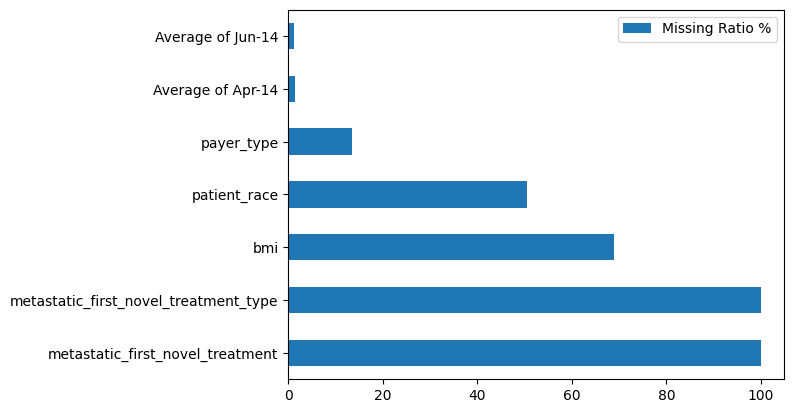

In [ ]:
# Plot features with high missing values
def plot_nas(df: pd.DataFrame):
  if df.isnull().sum().sum() != 0:
    na_df = df.isnull().sum() / len(df) * 100
    na_df = na_df.drop(na_df[na_df==0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({"Missing Ratio %" :na_df})
    missing_data_more_than_10_percent = missing_data[missing_data['Missing Ratio %'] > 1.0]
    missing_data_more_than_10_percent.plot(kind = 'barh')
    plt.show()
  else:
    print('No NAs found')

plot_nas(train_df)


<Axes: xlabel='payer_type'>

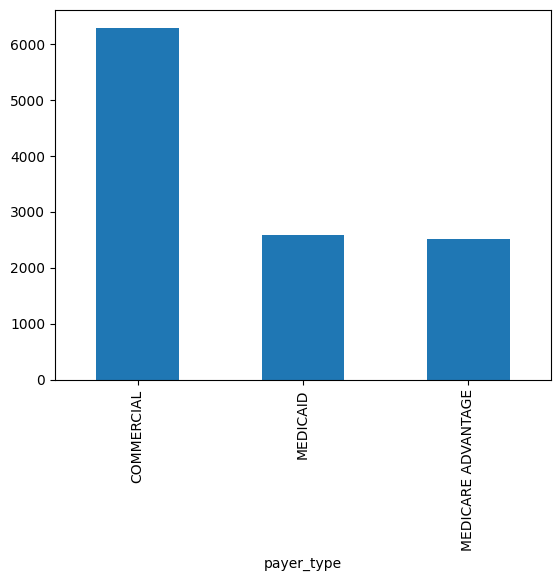

In [ ]:
train_df['payer_type'].value_counts().plot(kind='bar')

<Axes: xlabel='payer_type'>

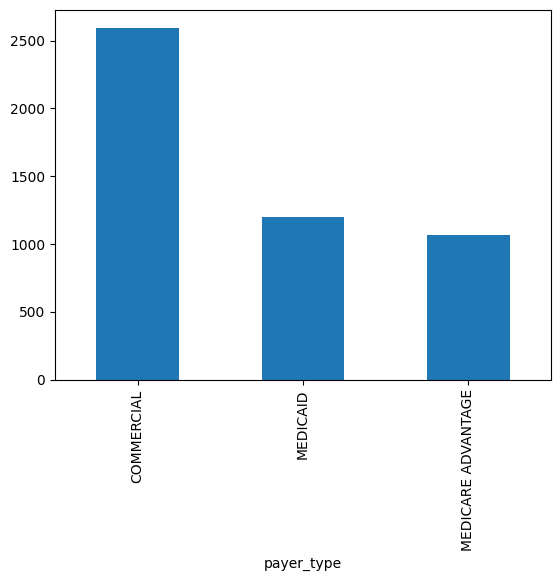

In [ ]:
test_df['payer_type'].value_counts().plot(kind='bar')

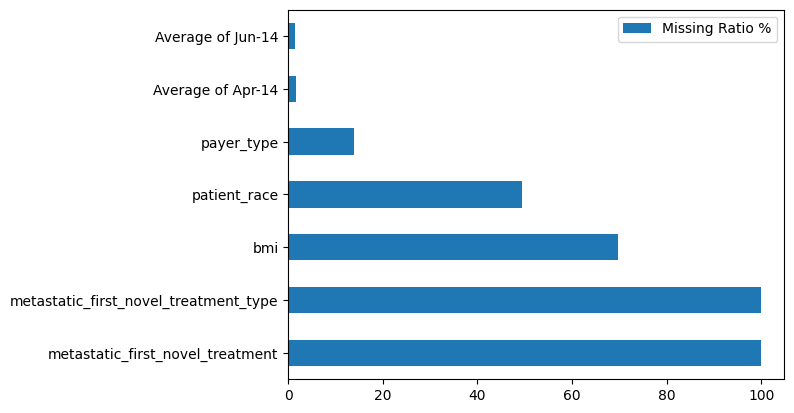

In [ ]:
plot_nas(test_df)

In [ ]:
train_df['bmi'].describe()

count   4102.0
mean      29.2
std        5.8
min       15.0
25%       24.8
50%       28.6
75%       33.0
max       97.0
Name: bmi, dtype: float64

<Axes: xlabel='patient_race'>

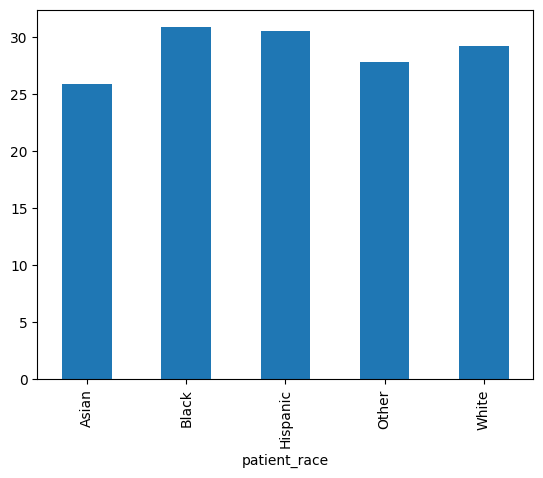

In [ ]:
train_df.groupby('patient_race')['bmi'].mean().plot(kind='bar')

<Axes: xlabel='patient_race'>

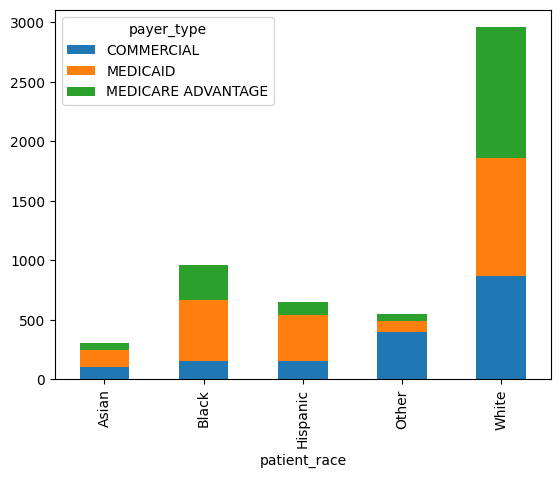

In [ ]:
pd.crosstab(train_df['patient_race'], train_df['payer_type']).plot(kind='bar', stacked=True)

<Axes: xlabel='patient_race'>

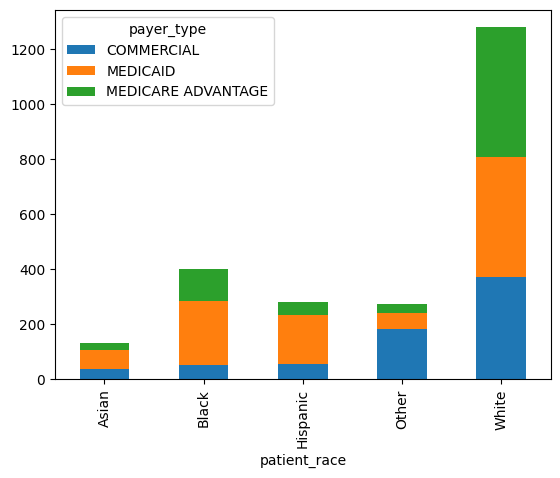

In [ ]:
pd.crosstab(test_df['patient_race'], test_df['payer_type']).plot(kind='bar', stacked=True)

# Data Cleaning

In [ ]:
import sklearn
sklearn.__version__

'1.2.2'

In [ ]:
# Impute missing values
"""
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=42)
imp.fix(train_df)
imp.transform(train_df)

plot_nas(train_df)
"""

'\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimp = IterativeImputer(max_iter=10, random_state=42)\nimp.fix(train_df)\nimp.transform(train_df)\n\nplot_nas(train_df)\n'

In [ ]:
# Transform string variable to numbers because KNNImputer only handle numerica variables
le = LabelEncoder()
train_df['payer_type_encode'] = le.fit_transform(train_df['payer_type'])
train_df['patient_race_encode'] = le.fit_transform(train_df['patient_race'])

In [ ]:
test_df['payer_type_encode'] = le.fit_transform(test_df['payer_type'])
test_df['patient_race_encode'] = le.fit_transform(test_df['patient_race'])

In [ ]:
print(train_df['payer_type'], train_df['payer_type_encode'])

0        COMMERCIAL
1               NaN
2        COMMERCIAL
3          MEDICAID
4        COMMERCIAL
            ...    
13168      MEDICAID
13169    COMMERCIAL
13170    COMMERCIAL
13171    COMMERCIAL
13172      MEDICAID
Name: payer_type, Length: 13173, dtype: object 0        0
1        3
2        0
3        1
4        0
        ..
13168    1
13169    0
13170    0
13171    0
13172    1
Name: payer_type_encode, Length: 13173, dtype: int64


In [ ]:
train_df['payer_type_encode'].replace(3, np.NaN, inplace=True)
train_df['payer_type_encode'] = train_df['payer_type_encode'].astype('Int64')
train_df['payer_type_encode']


0           0
1        <NA>
2           0
3           1
4           0
         ... 
13168       1
13169       0
13170       0
13171       0
13172       1
Name: payer_type_encode, Length: 13173, dtype: Int64

In [ ]:
test_df['payer_type_encode'].replace(3, np.NaN, inplace=True)
test_df['payer_type_encode'] = test_df['payer_type_encode'].astype('Int64')
test_df['payer_type_encode']


0          0
1       <NA>
2          0
3          0
4       <NA>
        ... 
5641    <NA>
5642       0
5643       0
5644       2
5645       2
Name: payer_type_encode, Length: 5646, dtype: Int64

In [ ]:
print(train_df['patient_race'], train_df['patient_race_encode'])

0             NaN
1           White
2             NaN
3        Hispanic
4             NaN
           ...   
13168    Hispanic
13169         NaN
13170         NaN
13171         NaN
13172    Hispanic
Name: patient_race, Length: 13173, dtype: object 0        5
1        4
2        5
3        2
4        5
        ..
13168    2
13169    5
13170    5
13171    5
13172    2
Name: patient_race_encode, Length: 13173, dtype: int64


In [ ]:
train_df['patient_race_encode'].replace(5, np.NaN, inplace=True)
train_df['patient_race_encode'] = train_df['patient_race_encode'].astype('Int64')
train_df['patient_race_encode']

0        <NA>
1           4
2        <NA>
3           2
4        <NA>
         ... 
13168       2
13169    <NA>
13170    <NA>
13171    <NA>
13172       2
Name: patient_race_encode, Length: 13173, dtype: Int64

In [ ]:
test_df['patient_race_encode'].replace(5, np.NaN, inplace=True)
test_df['patient_race_encode'] = test_df['patient_race_encode'].astype('Int64')
test_df['patient_race_encode']

0       <NA>
1          1
2       <NA>
3       <NA>
4          0
        ... 
5641       4
5642    <NA>
5643       0
5644       4
5645       4
Name: patient_race_encode, Length: 5646, dtype: Int64

In [ ]:
# Use KNNImputer to fill NAs on numerical variables
knn_imputer = KNNImputer(n_neighbors=5)
train_impute = knn_imputer.fit_transform(train_df[[col for col in train_df.columns if train_df[col].dtype != "object"]])
display(train_impute)

array([[2.68700e+05, 7.24000e+02, 3.90000e+01, ..., 1.91000e+02,
        0.00000e+00, 3.80000e+00],
       [4.84983e+05, 6.29000e+02, 5.50000e+01, ..., 3.30000e+01,
        4.00000e-01, 4.00000e+00],
       [2.77055e+05, 9.25000e+02, 5.90000e+01, ..., 1.57000e+02,
        0.00000e+00, 2.40000e+00],
       ...,
       [7.90904e+05, 9.28000e+02, 1.90000e+01, ..., 0.00000e+00,
        0.00000e+00, 2.40000e+00],
       [4.55518e+05, 4.81000e+02, 5.20000e+01, ..., 3.30000e+02,
        0.00000e+00, 3.40000e+00],
       [3.79418e+05, 9.00000e+02, 6.30000e+01, ..., 0.00000e+00,
        1.00000e+00, 2.00000e+00]])

In [ ]:
test_impute = knn_imputer.fit_transform(test_df[[col for col in test_df.columns if test_df[col].dtype != 'object']])
test_impute

array([[7.30681e+05, 7.13000e+02, 5.50000e+01, ..., 5.13400e+01,
        0.00000e+00, 3.20000e+00],
       [3.34212e+05, 2.83000e+02, 6.00000e+01, ..., 4.81000e+01,
        1.00000e+00, 1.00000e+00],
       [5.71362e+05, 7.94000e+02, 5.40000e+01, ..., 4.21300e+01,
        0.00000e+00, 2.60000e+00],
       ...,
       [3.04800e+05, 9.14000e+02, 4.40000e+01, ..., 5.94200e+01,
        0.00000e+00, 0.00000e+00],
       [2.67406e+05, 9.06000e+02, 6.60000e+01, ..., 5.93900e+01,
        2.00000e+00, 4.00000e+00],
       [8.73886e+05, 1.22000e+02, 7.30000e+01, ..., 2.89300e+01,
        2.00000e+00, 4.00000e+00]])

In [ ]:
train_impute_1 = pd.DataFrame(train_impute, columns= [col for col in train_df.columns if train_df[col].dtype != "object"])
plot_nas(train_impute_1)

No NAs found


In [ ]:
test_impute_1 = pd.DataFrame(test_impute, columns= [col for col in test_df.columns if test_df[col].dtype != "object"])
plot_nas(test_impute_1)

No NAs found


In [ ]:
train_impute_1 = pd.DataFrame(train_impute, columns= [col for col in train_df.columns if train_df[col].dtype != "object"])
train_impute_2 = pd.concat([train_impute_1, train_df[[col for col in train_df.columns if train_df[col].dtype == "object"]]], axis=1)
print(train_impute_1.shape)
print(train_impute_2.shape)
print(train_df.shape)

(13173, 143)
(13173, 154)
(13173, 154)


In [ ]:
test_impute_1 = pd.DataFrame(test_impute, columns= [col for col in test_df.columns if test_df[col].dtype != "object"])
test_impute_2 = pd.concat([test_impute_1, test_df[[col for col in test_df.columns if test_df[col].dtype == "object"]]], axis=1)
print(test_impute_1.shape)
print(test_impute_2.shape)
print(test_df.shape)

(5646, 142)
(5646, 153)
(5646, 153)


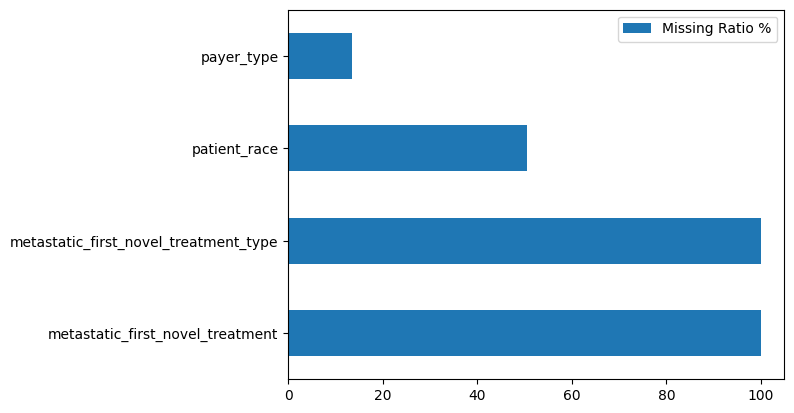

In [ ]:
plot_nas(train_impute_2)

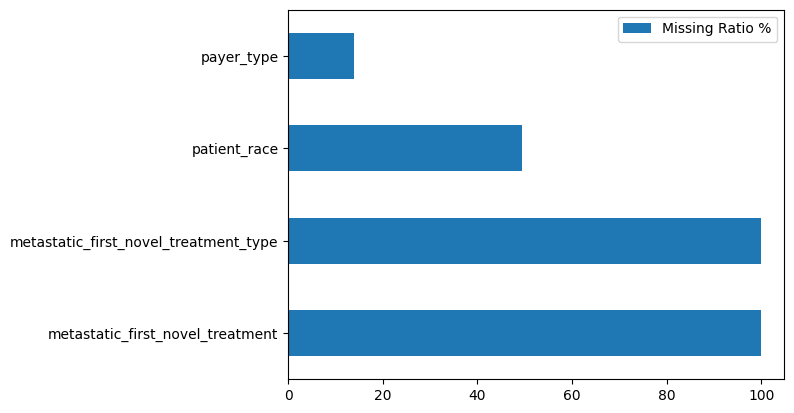

In [ ]:
plot_nas(test_impute_2)

In [ ]:
cat_col = [col for col in train_impute_2.columns if train_impute_2[col].dtype == "object"]
cat_col

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type']

In [ ]:
cat_col = [col for col in test_impute_2.columns if test_impute_2[col].dtype == "object"]
cat_col

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type']

In [ ]:
# Convert float after imputation to int, so to inverse encode, which can then use one hot encoder
train_impute_2['payer_type_encode'] = train_impute_2['payer_type_encode'].apply(round)
le.fit(train_df['payer_type'])
train_impute_2['payer_type_encode'] = le.inverse_transform(train_impute_2['payer_type_encode'])
train_impute_2['payer_type_encode']

0        COMMERCIAL
1        COMMERCIAL
2        COMMERCIAL
3          MEDICAID
4        COMMERCIAL
            ...    
13168      MEDICAID
13169    COMMERCIAL
13170    COMMERCIAL
13171    COMMERCIAL
13172      MEDICAID
Name: payer_type_encode, Length: 13173, dtype: object

In [ ]:
test_impute_2['payer_type_encode'] = test_impute_2['payer_type_encode'].apply(round)
le.fit(test_df['payer_type'])
test_impute_2['payer_type_encode'] = le.inverse_transform(test_impute_2['payer_type_encode'])
test_impute_2['payer_type_encode']

0               COMMERCIAL
1                 MEDICAID
2               COMMERCIAL
3               COMMERCIAL
4                 MEDICAID
               ...        
5641            COMMERCIAL
5642            COMMERCIAL
5643            COMMERCIAL
5644    MEDICARE ADVANTAGE
5645    MEDICARE ADVANTAGE
Name: payer_type_encode, Length: 5646, dtype: object

In [ ]:
train_impute_2['patient_race_encode'] = train_impute_2['patient_race_encode'].apply(round)
le.fit(train_impute_2['patient_race'])
train_impute_2['patient_race_encode'] = le.inverse_transform(train_impute_2['patient_race_encode'])
train_impute_2['patient_race_encode']

0           White
1           White
2        Hispanic
3        Hispanic
4           Other
           ...   
13168    Hispanic
13169       Other
13170    Hispanic
13171       Other
13172    Hispanic
Name: patient_race_encode, Length: 13173, dtype: object

In [ ]:
test_impute_2['patient_race_encode'] = test_impute_2['patient_race_encode'].apply(round)
le.fit(test_impute_2['patient_race'])
test_impute_2['patient_race_encode'] = le.inverse_transform(test_impute_2['patient_race_encode'])
test_impute_2['patient_race_encode']

0       Other
1       Black
2       Other
3       Other
4       Asian
        ...  
5641    White
5642    Other
5643    Asian
5644    White
5645    White
Name: patient_race_encode, Length: 5646, dtype: object

In [ ]:
train_impute_2 = train_impute_2.drop(['patient_race', 'payer_type', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)

In [ ]:
plot_nas(train_impute_2)

No NAs found


In [ ]:
test_impute_2 = test_impute_2.drop(['patient_race', 'payer_type', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)

In [ ]:
plot_nas(test_impute_2)

No NAs found


# Data Transformation

In [ ]:
# One hot encoder for payer_type
one_hot_encoder = OneHotEncoder(sparse=False)
payer_type_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['payer_type_encode']]))
payer_type_transform.columns = one_hot_encoder.get_feature_names_out(['payer_type_encode'])
payer_type_transform = payer_type_transform.astype(int)
payer_type_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,payer_type_encode_COMMERCIAL,payer_type_encode_MEDICAID,payer_type_encode_MEDICARE ADVANTAGE
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
13168,0,1,0
13169,1,0,0
13170,1,0,0
13171,1,0,0


In [ ]:

payer_type_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['payer_type_encode']]))
payer_type_transform.columns = one_hot_encoder.get_feature_names_out(['payer_type_encode'])
payer_type_transform = payer_type_transform.astype(int)
payer_type_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,payer_type_encode_COMMERCIAL,payer_type_encode_MEDICAID,payer_type_encode_MEDICARE ADVANTAGE
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
5641,1,0,0
5642,1,0,0
5643,1,0,0
5644,0,0,1


In [ ]:
# One hot encoder for patient race
patient_race_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['patient_race_encode']]))
patient_race_transform.columns = one_hot_encoder.get_feature_names_out(['patient_race_encode'])
patient_race_transform = patient_race_transform.astype(int)
patient_race_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_race_encode_Asian,patient_race_encode_Black,patient_race_encode_Hispanic,patient_race_encode_Other,patient_race_encode_White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
13168,0,0,1,0,0
13169,0,0,0,1,0
13170,0,0,1,0,0
13171,0,0,0,1,0


In [ ]:
patient_race_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['patient_race_encode']]))
patient_race_transform.columns = one_hot_encoder.get_feature_names_out(['patient_race_encode'])
patient_race_transform = patient_race_transform.astype(int)
patient_race_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_race_encode_Asian,patient_race_encode_Black,patient_race_encode_Hispanic,patient_race_encode_Other,patient_race_encode_White
0,0,0,0,1,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,1,0,0,0,0
...,...,...,...,...,...
5641,0,0,0,0,1
5642,0,0,0,1,0
5643,1,0,0,0,0
5644,0,0,0,0,1


In [ ]:
breast_cancer_diagnosis_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['breast_cancer_diagnosis_code']]))
breast_cancer_diagnosis_transform.columns = one_hot_encoder.get_feature_names_out(['breast_cancer_diagnosis_code'])
breast_cancer_diagnosis_transform = breast_cancer_diagnosis_transform.astype(int)
breast_cancer_diagnosis_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1743,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1746,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_19881,breast_cancer_diagnosis_code_C5001,...,breast_cancer_diagnosis_code_C5081,breast_cancer_diagnosis_code_C50811,breast_cancer_diagnosis_code_C50812,breast_cancer_diagnosis_code_C50819,breast_cancer_diagnosis_code_C509,breast_cancer_diagnosis_code_C5091,breast_cancer_diagnosis_code_C50911,breast_cancer_diagnosis_code_C50912,breast_cancer_diagnosis_code_C50919,breast_cancer_diagnosis_code_C50922
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13169,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13171,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
breast_cancer_diagnosis_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['breast_cancer_diagnosis_code']]))
breast_cancer_diagnosis_transform.columns = one_hot_encoder.get_feature_names_out(['breast_cancer_diagnosis_code'])
breast_cancer_diagnosis_transform = breast_cancer_diagnosis_transform.astype(int)
breast_cancer_diagnosis_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1743,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1746,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_19881,breast_cancer_diagnosis_code_C50011,...,breast_cancer_diagnosis_code_C50611,breast_cancer_diagnosis_code_C50612,breast_cancer_diagnosis_code_C5081,breast_cancer_diagnosis_code_C50811,breast_cancer_diagnosis_code_C50812,breast_cancer_diagnosis_code_C50819,breast_cancer_diagnosis_code_C5091,breast_cancer_diagnosis_code_C50911,breast_cancer_diagnosis_code_C50912,breast_cancer_diagnosis_code_C50919
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5643,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
cat_cols = [col for col in train_impute_2.columns if train_impute_2[col].dtype == 'object']
cat_cols

['payer_type_encode',
 'patient_race_encode',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code']

In [ ]:
train_impute_2.groupby('Region').size()

Region
Midwest      3766
Northeast    1721
South        3960
West         3726
dtype: int64

In [ ]:
train_impute_2.groupby('Division').size()

Division
East North Central    3010
East South Central     494
Middle Atlantic       1721
Mountain              1029
Pacific               2697
South Atlantic        1968
West North Central     756
West South Central    1498
dtype: int64

In [ ]:
train_impute_2.groupby('metastatic_cancer_diagnosis_code').size()

metastatic_cancer_diagnosis_code
C770      140
C771      145
C772       29
C773     7308
C774        3
         ... 
C798        2
C7981     453
C7982       8
C7989     330
C799      259
Length: 43, dtype: int64

In [ ]:
Region_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['Region']]))
Region_transform.columns = one_hot_encoder.get_feature_names_out(['Region'])
Region_transform = Region_transform.astype(int)
Region_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Region_Midwest,Region_Northeast,Region_South,Region_West
0,0,0,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
13168,0,1,0,0
13169,0,0,1,0
13170,0,0,0,1
13171,1,0,0,0


In [ ]:
Region_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['Region']]))
Region_transform.columns = one_hot_encoder.get_feature_names_out(['Region'])
Region_transform = Region_transform.astype(int)
Region_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Region_Midwest,Region_Northeast,Region_South,Region_West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
5641,0,0,0,1
5642,0,0,1,0
5643,0,0,0,1
5644,0,0,0,1


In [ ]:
Division_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['Division']]))
Division_transform.columns = one_hot_encoder.get_feature_names_out(['Division'])
Region_transform = Region_transform.astype(int)
Region_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Region_Midwest,Region_Northeast,Region_South,Region_West
0,0,0,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
13168,0,1,0,0
13169,0,0,1,0
13170,0,0,0,1
13171,1,0,0,0


In [ ]:
Division_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['Division']]))
Division_transform.columns = one_hot_encoder.get_feature_names_out(['Division'])
Region_transform = Region_transform.astype(int)
Region_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Region_Midwest,Region_Northeast,Region_South,Region_West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
5641,0,0,0,1
5642,0,0,1,0
5643,0,0,0,1
5644,0,0,0,1


In [ ]:
metastatic_cancer_diagnosis_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['metastatic_cancer_diagnosis_code']]))
metastatic_cancer_diagnosis_transform.columns = one_hot_encoder.get_feature_names_out(['metastatic_cancer_diagnosis_code'])
metastatic_cancer_diagnosis_transform = metastatic_cancer_diagnosis_transform.astype(int)
metastatic_cancer_diagnosis_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,metastatic_cancer_diagnosis_code_C770,metastatic_cancer_diagnosis_code_C771,metastatic_cancer_diagnosis_code_C772,metastatic_cancer_diagnosis_code_C773,metastatic_cancer_diagnosis_code_C774,metastatic_cancer_diagnosis_code_C775,metastatic_cancer_diagnosis_code_C778,metastatic_cancer_diagnosis_code_C779,metastatic_cancer_diagnosis_code_C7800,metastatic_cancer_diagnosis_code_C7801,...,metastatic_cancer_diagnosis_code_C7961,metastatic_cancer_diagnosis_code_C7962,metastatic_cancer_diagnosis_code_C7970,metastatic_cancer_diagnosis_code_C7971,metastatic_cancer_diagnosis_code_C7972,metastatic_cancer_diagnosis_code_C798,metastatic_cancer_diagnosis_code_C7981,metastatic_cancer_diagnosis_code_C7982,metastatic_cancer_diagnosis_code_C7989,metastatic_cancer_diagnosis_code_C799
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13171,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
metastatic_cancer_diagnosis_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['metastatic_cancer_diagnosis_code']]))
metastatic_cancer_diagnosis_transform.columns = one_hot_encoder.get_feature_names_out(['metastatic_cancer_diagnosis_code'])
metastatic_cancer_diagnosis_transform = metastatic_cancer_diagnosis_transform.astype(int)
metastatic_cancer_diagnosis_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,metastatic_cancer_diagnosis_code_C770,metastatic_cancer_diagnosis_code_C771,metastatic_cancer_diagnosis_code_C772,metastatic_cancer_diagnosis_code_C773,metastatic_cancer_diagnosis_code_C774,metastatic_cancer_diagnosis_code_C775,metastatic_cancer_diagnosis_code_C778,metastatic_cancer_diagnosis_code_C779,metastatic_cancer_diagnosis_code_C7800,metastatic_cancer_diagnosis_code_C7801,...,metastatic_cancer_diagnosis_code_C7951,metastatic_cancer_diagnosis_code_C7952,metastatic_cancer_diagnosis_code_C7960,metastatic_cancer_diagnosis_code_C7961,metastatic_cancer_diagnosis_code_C7970,metastatic_cancer_diagnosis_code_C798,metastatic_cancer_diagnosis_code_C7981,metastatic_cancer_diagnosis_code_C7982,metastatic_cancer_diagnosis_code_C7989,metastatic_cancer_diagnosis_code_C799
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5643,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5644,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
patient_state_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['patient_state']]))
patient_state_transform.columns = one_hot_encoder.get_feature_names_out(['patient_state'])
patient_state_transform = patient_state_transform.astype(int)
patient_state_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_state_AK,patient_state_AL,patient_state_AR,patient_state_AZ,patient_state_CA,patient_state_CO,patient_state_DC,patient_state_DE,patient_state_FL,patient_state_GA,...,patient_state_SC,patient_state_SD,patient_state_TN,patient_state_TX,patient_state_UT,patient_state_VA,patient_state_WA,patient_state_WI,patient_state_WV,patient_state_WY
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13170,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
patient_state_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['patient_state']]))
patient_state_transform.columns = one_hot_encoder.get_feature_names_out(['patient_state'])
patient_state_transform = patient_state_transform.astype(int)
patient_state_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_state_AK,patient_state_AL,patient_state_AR,patient_state_AZ,patient_state_CA,patient_state_CO,patient_state_DC,patient_state_DE,patient_state_FL,patient_state_GA,...,patient_state_SC,patient_state_SD,patient_state_TN,patient_state_TX,patient_state_UT,patient_state_VA,patient_state_WA,patient_state_WI,patient_state_WV,patient_state_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5642,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5643,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5644,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
patient_gender_transform = pd.DataFrame(one_hot_encoder.fit_transform(train_impute_2[['patient_gender']]))
patient_gender_transform.columns = one_hot_encoder.get_feature_names_out(['patient_gender'])
patient_gender_transform = patient_gender_transform.astype(int)
patient_gender_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_gender_F
0,1
1,1
2,1
3,1
4,1
...,...
13168,1
13169,1
13170,1
13171,1


In [ ]:
patient_gender_transform = pd.DataFrame(one_hot_encoder.fit_transform(test_impute_2[['patient_gender']]))
patient_gender_transform.columns = one_hot_encoder.get_feature_names_out(['patient_gender'])
patient_gender_transform = patient_gender_transform.astype(int)
patient_gender_transform

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,patient_gender_F
0,1
1,1
2,1
3,1
4,1
...,...
5641,1
5642,1
5643,1
5644,1


In [ ]:
cat_cols = [col for col in train_impute_2.columns if train_impute_2[col].dtype == 'object']
cat_cols

['payer_type_encode',
 'patient_race_encode',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code']

In [ ]:
plot_nas(train_impute_2)

No NAs found


In [ ]:
train_transform = pd.concat([train_impute_2, payer_type_transform, patient_race_transform, patient_state_transform, Region_transform, Division_transform, patient_gender_transform, breast_cancer_diagnosis_transform, metastatic_cancer_diagnosis_transform], axis=1)

In [ ]:
plot_nas(train_transform)

No NAs found


In [ ]:
test_transform = pd.concat([test_impute_2, payer_type_transform, patient_race_transform, patient_state_transform, Region_transform, Division_transform, patient_gender_transform, breast_cancer_diagnosis_transform, metastatic_cancer_diagnosis_transform], axis=1)

In [ ]:
plot_nas(test_transform)

No NAs found


In [ ]:
print(train_impute_2.shape)
print(train_transform.shape)

(13173, 150)
(13173, 305)


In [ ]:
print(test_transform.shape)

(5646, 293)


In [ ]:
train_transform = train_transform.drop(['payer_type_encode', 'patient_race_encode', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code'], axis=1)
train_transform.shape

(13173, 296)

In [ ]:
test_transform = test_transform.drop(['payer_type_encode', 'patient_race_encode', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code'], axis=1)
test_transform.shape

(5646, 284)

In [ ]:
cat_cols = [col for col in train_transform.columns if train_transform[col].dtype == 'object']
cat_cols

[]

In [ ]:
cat_cols = [col for col in test_transform.columns if test_transform[col].dtype == 'object']
cat_cols

[]

# Scaling training and test data

In [ ]:
y_train = train_transform['metastatic_diagnosis_period']
y_train

0       191.0
1        33.0
2       157.0
3       146.0
4       286.0
         ... 
13168   106.0
13169    92.0
13170     0.0
13171   330.0
13172     0.0
Name: metastatic_diagnosis_period, Length: 13173, dtype: float64

In [ ]:
X_train = train_transform.drop(['metastatic_diagnosis_period'], axis=1)
X_train.shape

(13173, 295)

In [ ]:
plot_nas(X_train)

No NAs found


In [ ]:
# Add features in training data that are missing in training data but found in test data

missing_cols_train = [col for col in test_transform.columns if col not in X_train.columns]

for feature in missing_cols_train:
  X_train[feature] = 0

X_train.shape


(13173, 298)

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_cols

[]

In [ ]:
# Add features in test data that are missing in test data but found in train data

missing_cols_test = [col for col in X_train.columns if col not in test_transform.columns]

for feature in missing_cols_test:
  test_transform[feature] = 0

test_transform.shape


(5646, 298)

In [ ]:
cat_cols = [col for col in test_transform.columns if test_transform[col].dtype == 'object']
cat_cols

[]

In [ ]:
# Make sure test data features have the same order as training data order, for StandardScaler to work

X_test = test_transform[X_train.columns]

In [ ]:
cat_cols = [col for col in X_test.columns if X_test[col].dtype == 'object']
cat_cols

[]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(13173, 298)
(5646, 298)


In [ ]:
X_train

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,metastatic_cancer_diagnosis_code_C7971,metastatic_cancer_diagnosis_code_C7972,metastatic_cancer_diagnosis_code_C798,metastatic_cancer_diagnosis_code_C7981,metastatic_cancer_diagnosis_code_C7982,metastatic_cancer_diagnosis_code_C7989,metastatic_cancer_diagnosis_code_C799,breast_cancer_diagnosis_code_C5021,metastatic_cancer_diagnosis_code_C7830,metastatic_cancer_diagnosis_code_C7919
0,268700.0,724.0,39.0,32.9,3924.9,82.6,42.6,11.6,13.0,10.9,...,0,0,0,0,0,0,0,0,0,0
1,484983.0,629.0,55.0,35.4,2745.4,51.8,43.5,11.2,12.2,11.4,...,0,0,0,0,0,0,0,0,0,0
2,277055.0,925.0,59.0,27.1,38343.2,700.3,36.3,13.3,15.7,13.5,...,0,0,0,0,0,0,0,0,0,0
3,320055.0,900.0,59.0,28.6,36054.1,5294.3,36.6,9.8,11.3,17.2,...,0,0,0,0,0,0,0,0,0,0
4,190386.0,934.0,71.0,27.0,13700.4,400.5,41.8,10.0,16.4,13.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,588544.0,191.0,59.0,27.2,31948.5,5512.2,35.7,10.8,10.9,18.2,...,0,0,0,0,0,0,0,0,0,0
13169,393047.0,757.0,73.0,30.7,9309.4,204.7,40.9,11.3,14.6,12.1,...,0,0,0,0,0,0,0,0,0,0
13170,790904.0,928.0,19.0,22.3,39121.9,2295.9,38.2,11.9,13.3,14.2,...,0,0,0,0,0,0,1,0,0,0
13171,455518.0,481.0,52.0,31.3,23266.1,743.6,41.5,10.9,13.6,12.7,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,296,297
0,-1.1,0.6,-1.5,0.9,-1.2,-0.4,0.5,0.3,0.1,-0.7,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
1,-0.3,0.2,-0.3,1.6,-1.3,-0.4,0.7,0.1,-0.3,-0.5,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
2,-1.1,1.3,-0.0,-0.5,1.3,-0.3,-1.1,1.4,1.4,0.1,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
3,-0.9,1.2,-0.0,-0.2,1.1,0.9,-1.0,-0.9,-0.8,1.2,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
4,-1.4,1.3,0.9,-0.6,-0.5,-0.4,0.3,-0.7,1.8,-0.1,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,0.1,-1.4,-0.0,-0.5,0.8,1.0,-1.2,-0.2,-1.0,1.4,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
13169,-0.6,0.7,1.0,0.4,-0.8,-0.4,0.1,0.1,0.9,-0.4,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
13170,0.9,1.3,-3.0,-1.8,1.3,0.1,-0.6,0.5,0.3,0.3,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,7.1,0.0,0.0,0.0
13171,-0.4,-0.3,-0.6,0.5,0.2,-0.3,0.2,-0.1,0.4,-0.2,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0


In [ ]:
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,296,297
0,0.7,0.5,-0.3,-0.4,-1.2,-0.4,0.2,0.2,0.3,-0.6,...,-0.0,-0.0,-0.0,5.3,-0.0,-0.2,-0.1,0.0,0.0,0.0
1,-0.9,-1.0,0.1,2.7,-0.7,-0.4,-0.2,0.1,0.4,0.5,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
2,0.1,0.8,-0.4,0.8,-0.1,-0.2,-2.5,-0.1,3.1,2.9,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
3,1.4,-0.7,0.3,-0.5,-0.9,-0.4,0.9,-0.6,-0.1,-0.5,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
4,-1.3,1.5,0.2,-0.8,0.6,-0.2,-0.2,0.7,-0.2,-0.6,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,0.4,0.8,0.3,0.6,1.0,-0.1,-0.6,1.1,-0.3,-0.0,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
5642,1.2,-1.0,-0.2,2.7,1.4,-0.2,-0.7,1.5,0.8,-0.4,...,-0.0,-0.0,-0.0,-0.2,-0.0,6.2,-0.1,0.0,0.0,0.0
5643,-1.0,1.3,-1.2,-0.4,1.4,0.6,-0.7,0.3,-0.7,0.4,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0
5644,-1.1,1.2,0.5,0.7,1.5,0.3,-0.9,-0.2,1.4,0.8,...,-0.0,-0.0,-0.0,-0.2,-0.0,-0.2,-0.1,0.0,0.0,0.0


In [ ]:
plot_nas(X_train_scaled)

No NAs found


# Deep Neural Network

In [ ]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(298,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # output single neuron for regression
])

In [ ]:
# Compile the model
"""
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train_scaled):
  X_train_i, X_val_i = X_train_scaled[train_index], X_train_scaled[val_index]
  y_train_i, y_val_i = y_train[train_index], y_train[val_index]

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolution_error'])

  model.fit(X_train_i, y_train_i, epochs=100, batch_size=32, validation_data=(X_val_i, y_val_i))
  """

"\nfor train_index, val_index in kf.split(X_train_scaled):\n  X_train_i, X_val_i = X_train_scaled[train_index], X_train_scaled[val_index]\n  y_train_i, y_val_i = y_train[train_index], y_train[val_index]\n\n  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\n  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolution_error'])\n\n  model.fit(X_train_i, y_train_i, epochs=100, batch_size=32, validation_data=(X_val_i, y_val_i))\n  "

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00003)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
371/371 [==============================] - 6s 8ms/step - loss: 6934.6543 - mean_squared_error: 6934.6543 - val_loss: 6978.2480 - val_mean_squared_error: 6978.2480
Epoch 2/50
371/371 [==============================] - 3s 8ms/step - loss: 6930.1284 - mean_squared_error: 6930.1284 - val_loss: 6980.8013 - val_mean_squared_error: 6980.8013
Epoch 3/50
371/371 [==============================] - 1s 3ms/step - loss: 6952.3032 - mean_squared_error: 6952.3032 - val_loss: 6982.0415 - val_mean_squared_error: 6982.0415
Epoch 4/50
371/371 [==============================] - 1s 2ms/step - loss: 6968.6460 - mean_squared_error: 6968.6460 - val_loss: 6981.8716 - val_mean_squared_error: 6981.8716
Epoch 5/50
371/371 [==============================] - 1s 3ms/step - loss: 6928.5522 - mean_squared_error: 6928.5522 - val_loss: 6985.2168 - val_mean_squared_error: 6985.2168
Epoch 6/50
371/371 [==============================] - 1s 4ms/step - loss: 6911.9731 - mean_squared_error: 6911.9731 - val_loss: 69

In [ ]:
predictions = model.predict(X_test_scaled)

177/177 [==============================] - 0s 2ms/step


In [ ]:
predictions_2 = np.where(predictions < 0, 0, predictions)
predictions_2 = np.round(predictions_2)
predictions_2

array([[244.],
       [ 76.],
       [211.],
       ...,
       [222.],
       [ 79.],
       [ 72.]], dtype=float32)

In [ ]:
patient_id = test_df['patient_id']
patient_id

0       730681
1       334212
2       571362
3       907331
4       208382
         ...  
5641    649011
5642    869024
5643    304800
5644    267406
5645    873886
Name: patient_id, Length: 5646, dtype: int64

In [ ]:
pred_df = pd.DataFrame(predictions_2)

In [ ]:
data = {
    'patient_id': patient_id
}

id_df = pd.DataFrame(data)

In [ ]:
id_df.head(5)

In [ ]:
pred_df.to_csv('predictions2.csv', index=True)
id_df.to_csv('patient_id.csv', index=True)

In [ ]:
files.download('predictions2.csv')
files.download('patient_id.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>